In [1]:
using LinearAlgebra
using Plots
using LaTeXStrings #Latex Syntax for Plotting
using DelimitedFiles
using ITensors
using ITensors.HDF5
using Statistics
# ITensors.compile()

$$ H = -J\sum_{j = 1}^{N - 1}( b^{\dagger}_{j}b_{j+1} + h.c.)+\frac{U}{2} \sum_{j = 1}^{N} n_{j}(n_{j} - 1)$$

**Exact Diagonalization:**

In [2]:
function Create_Annihilation_Creation_Operators(N)
    # N is the Number of Bosons. Note: Creation is b† and annihilation is b.
    
    Creation = zeros(N+1, N+1) 
    for i=1:N
        Creation[i+1,i] = sqrt(i)
    end
    Annihilation = Adjoint(Creation)
    return Creation, Annihilation
end

function Enlarge_Matrix_site_j(j, N, matrix)
    # I⊗...⊗I⊗M⊗I...⊗I

    Identity = zeros(size(matrix))
    for i=1:size(matrix)[1]
        Identity[i,i] = 1
    end
    
    M = Identity
    
    if j == 1
        M = matrix
    end    
    
    for i=2:N 
        if i == j
        M = kron(M, matrix)
        else
        M = kron(M, Identity)        
        end
    end

    return M
end

function Enlarge_Matrix_i_Matrix_j(i,j,N, matrix_i, matrix_j)
    # I⊗...⊗I⊗M_i⊗I...⊗I⊗M_j⊗I⊗I...⊗I

    Identity = zeros(size(matrix_i))
    for i=1:size(matrix_i)[1]
        Identity[i,i] = 1
    end

    M = Identity

    
    if j == 1
        M = matrix_j
    end    

    if i == 1
        M = matrix_i
    end   
    
    for k=2:N 
        if k == j
        M = kron(M, matrix_j)
        elseif k == i
        M = kron(M, matrix_i)
        else
        M = kron(M, Identity)        
        end
    end

    return M
end

Enlarge_Matrix_i_Matrix_j (generic function with 1 method)

**Test 0: Definition of Creation and Annihilation Operators**

In [3]:
Creation, Annihilation = Create_Annihilation_Creation_Operators(3)
Identity = zeros(4,4)
for i=1:4
    Identity[i,i] = 1
end
kron(Identity,Creation) == Enlarge_Matrix_site_j(2,2,Creation)
kron(Identity,Creation, Annihilation) == Enlarge_Matrix_i_Matrix_j(2,3,3,Creation, Annihilation)

true

In [4]:
Creation

4×4 Matrix{Float64}:
 0.0  0.0      0.0      0.0
 1.0  0.0      0.0      0.0
 0.0  1.41421  0.0      0.0
 0.0  0.0      1.73205  0.0

In [5]:
function Build_ED_Bose_Hubbard_Hamiltonian(N_Bosons, L_Chain, J, U)
    # H = ∑ J(I⊗...⊗I...⊗I⊗bdag⊗b⊗I⊗...I⊗...⊗I + h.c.) +0.5*U(I⊗...⊗I...⊗I⊗n⊗n⊗I⊗...I⊗...⊗I - ⊗...⊗I⊗n⊗I⊗I...⊗I)

    H = zeros((N_Bosons+1)^L_Chain, (N_Bosons+1)^L_Chain)

    Creation, Annihilation = Create_Annihilation_Creation_Operators(N_Bosons)
    Particle_Number_Op = Creation*Annihilation

    for i=1:L_Chain-1
        j = i + 1 #nearest neighbor in 1D. Let's consider just OBC
        BdagB_Term = Enlarge_Matrix_i_Matrix_j(i,j,L_Chain, Creation, Annihilation)
        BBdag_Term = Enlarge_Matrix_i_Matrix_j(i,j,L_Chain, Annihilation, Creation)
        H = H -J*(BdagB_Term + BBdag_Term)
    end

    for i=1:L_Chain
        nini_Term =  Enlarge_Matrix_site_j(i, L_Chain, Particle_Number_Op*Particle_Number_Op)
        ni_Term = Enlarge_Matrix_site_j(i, L_Chain, Particle_Number_Op)
        H = H + 0.5*U*(nini_Term - ni_Term)
    end    

    return H
end

function Time_Evolution_Operator_ED(t, H)
    #|Ψ(t)> = exp(-itH)|Ψ(0)>

    return U = exp(-1im*t*H)   
end

Time_Evolution_Operator_ED (generic function with 1 method)

**Tensor Networks:**

In [26]:
function Build_MPO_Bose_Hubbard_Hamiltonian(Max_N_Bosons, L_Chain, J, U, sites = false, symmetries = false)
    # H = ∑ J(I⊗...⊗I...⊗I⊗bdag⊗b⊗I⊗...I⊗...⊗I + h.c.) +0.5*U(I⊗...⊗I...⊗I⊗n⊗n⊗I⊗...I⊗...⊗I - ⊗...⊗I⊗n⊗I⊗I...⊗I)

    if sites == false 
        sites = siteinds("Qudit",L_Chain, dim = Max_N_Bosons + 1, conserve_qns = symmetries) #conserve_qns = true means that the number of bosons is conserved.
    end    
    # Input the operator terms 
    
    os = OpSum() 
    for i=1:L_Chain-1
        os += -J,"A",i,"Adag",i+1 
        os += -J,"Adag",i,"A",i+1 
    end 

    for i=1:L_Chain
        os += 0.5*U,"N * N",i
        os += -0.5*U,"N",i
    end 
    
    # Convert these terms to an MPO 
    H = MPO(os,sites)
    return H, sites
end

function Calculate_Correlation_Adagi_Aj(psi, i, j)
    # <Ψ(t)|b†_i*b_j|Ψ(t)>
    
    sites = siteinds(psi)
    Op_1 = op("Adag", sites[i])
    Op_2 = op("A", sites[j])

    return inner(psi, apply(Op_1, apply(Op_2,psi)))
end

function TEBD_Time_Evolution_Expected_Value_Correlation(t, Psi_0, Max_N_Bosons, L_Chain, J, U, site_i_corr = 1,  site_j_corr = 2, maxdim = 40, output = false)
    #|Ψ(t)> = exp(-itH)|Ψ(0)> #Main Function

    N = length(Psi_0)
    
    cutoff = 1E-8
    
    dt = 0.01
    
    s = siteinds(Psi_0)
    
    # Make gates (1,2),(2,3),(3,4),...
    Evolution_Gates = ITensor[]    

    for j in 1:(N - 1)
    
        s1 = s[j]
        s2 = s[j + 1]

        hj = -J*op("A", s1)*op("Adag", s2) -J*op("Adag", s1)*op("A", s2) 
        hj = hj + 0.5*U*op("N * N", s1)*op("Id", s2) -0.5*U*op("N", s1)*op("Id", s2)
    
        if j == N-1
            hj = hj + 0.5*U*op("Id", s1)*op("N * N", s2) -0.5*U*op("Id", s1)*op("N", s2)
        end        
        
        push!(Evolution_Gates, exp(-im * dt/ 2 * hj))
    
    end

    append!(Evolution_Gates, reverse(Evolution_Gates))

    # Correlation_Values = [real(correlation_matrix(Psi_0,"Adag","A")[site_i_corr,site_j_corr])] 
    Correlation_Values = [real(Calculate_Correlation_Adagi_Aj(Psi_0, site_i_corr, site_j_corr))] 

    Times = [0.0]
    
    Psi_t = Psi_0    
        
    for time in dt:dt:t
        Psi_t = apply(Evolution_Gates, Psi_t; cutoff, maxdim)  #Each that apply is executed an SVD is also executed, maxdim is the maximum of the dimension that we will use from the SVD.
        normalize!(Psi_t)

        append!(Times, time)
        # append!(Correlation_Values, real(correlation_matrix(Psi_t,"Adag","A")[site_i_corr,site_j_corr]))
        append!(Correlation_Values, real(Calculate_Correlation_Adagi_Aj(Psi_t, site_i_corr, site_j_corr)))

        if output == true
            println("Correlations for t = "*string(time)*" calculated.")
        end
    end
    
    return Correlation_Values, Times
end

function determine_sites_with_distance_from_center(N, distance)

    Center = round(N/2)
    i = Center 
    j = Center
        
    for k = 1:N-1
        Center = round(N/2)
        if k % 2 != 0
            i = i 
            j = j + 1
        else
            i = i - 1
            j = j 
        end

        if abs(i-j) == distance
            return trunc(Int,i), trunc(Int,j)
        end
    end
end

function TEBD_Time_Evolution_Expected_Value_Correlation_distance(t, Psi_0, Max_N_Bosons, L_Chain, J, U, maximum_distance = 1, maxdim = 40)
    #|Ψ(t)> = exp(-itH)|Ψ(0)> 

    N = length(Psi_0)
    
    cutoff = 1E-8
    dt = 0.01
    
    s = siteinds(Psi_0)
    
    # Make gates (1,2),(2,3),(3,4),...
    Evolution_Gates = ITensor[]    

    for j in 1:(N - 1)
    
        s1 = s[j]
        s2 = s[j + 1]

        hj = -J*op("A", s1)*op("Adag", s2) -J*op("Adag", s1)*op("A", s2) 
        hj = hj + 0.5*U*op("N * N", s1)*op("Id", s2) -0.5*U*op("N", s1)*op("Id", s2)
    
        if j == N-1
            hj = hj + 0.5*U*op("Id", s1)*op("N * N", s2) -0.5*U*op("Id", s1)*op("N", s2)
        end        
        
        push!(Evolution_Gates, exp(-im * dt/ 2 * hj))
    
    end

    append!(Evolution_Gates, reverse(Evolution_Gates))

    # Correlation_Values_Since_Site_1 =  zeros((length(0:dt:t), maximum_distance))
    Correlation_Values_Since_Site_Center =  zeros((length(0:dt:t), maximum_distance))

    Correlation_Matrix = correlation_matrix(Psi_0,"Adag","A")

    for distance=1:maximum_distance
        # Correlation_Values_Since_Site_1[1, trunc(Int,distance)] =  real(Correlation_Matrix[1,trunc(Int,1 + distance)]) #Measuring distance since site 1.
        # println(trunc(Int,1 + distance))
        
        i,j = determine_sites_with_distance_from_center(N, distance) #Measuring distance since center site.
        Correlation_Values_Since_Site_Center[1,trunc(Int,distance)] = real(Correlation_Matrix[i,j])
    end

    Times = [0.0]
    
    Psi_t = Psi_0    
        
    for time in dt:dt:t
        Psi_t = apply(Evolution_Gates, Psi_t; cutoff, maxdim)  #Each that apply is executed an SVD is also executed, maxdim is the maximum of the dimension that we will use from the SVD.
        normalize!(Psi_t)

        Correlation_Matrix = correlation_matrix(Psi_t,"Adag","A")

        for distance=1:maximum_distance  #Measuring distance since center site.
            # Correlation_Values_Since_Site_1[trunc(Int, time/dt) + 1, trunc(Int,distance)] =  real(Correlation_Matrix[1,trunc(Int, 1 + distance)]) #Measuring distance since site 1.

            i,j = determine_sites_with_distance_from_center(N, distance) #Measuring distance since center site.
            Correlation_Values_Since_Site_Center[trunc(Int, time/dt) + 1,trunc(Int,distance)] = real(Correlation_Matrix[i,j])
        end
            
        append!(Times, time)

    end

    # return Correlation_Values_Since_Site_Center, Correlation_Values_Since_Site_1, Times
    return Correlation_Values_Since_Site_Center, Times

end

TEBD_Time_Evolution_Expected_Value_Correlation_distance (generic function with 3 methods)

**Test 1: Determination of EigenValues.**

In [7]:
#ED
H = Build_ED_Bose_Hubbard_Hamiltonian(3, 6, 1, 1)
Eigenvalues = eigen(H).values
print(Eigenvalues[1], Eigenvalues[2], Eigenvalues[3])

-9.48479861742051-9.355368957128752-9.276847906537574

In [8]:
#Itensor
H_MPO, sites = Build_MPO_Bose_Hubbard_Hamiltonian(3,6,1,1)

nsweeps = 10
maxdim = [10,20,100,200,200] #maxdim - integer or array of integers specifying the maximum size allowed for the bond dimension or rank of the MPS being optimized
cutoff = [1E-10] #maxdim - integer or array of integers specifying the maximum size allowed for the bond dimension or rank of the MPS being optimized

energy_ground_state, psi_ground_state = dmrg(H_MPO,randomMPS(sites,4); nsweeps, maxdim, cutoff, outputlevel = 0) #randomMPS(sites,4) is the start point. Is a random MPS with bond dimension = number of bosons + 1
energy_1_excited_state, psi_1_excited_state = dmrg(H_MPO,[psi_ground_state], randomMPS(sites,4); nsweeps, maxdim, cutoff, outputlevel = 0) 
energy_2_excited_state, psi_2_excited_state = dmrg(H_MPO,[psi_ground_state, psi_1_excited_state], randomMPS(sites,4); nsweeps, maxdim, cutoff, outputlevel = 0) 

println(energy_ground_state, energy_1_excited_state, energy_2_excited_state) #Using ITensors

# ? randomMPS #Important if we want to include the conservation of nqs

-9.484798616390309-9.355367648700904-9.276848931762668


In [9]:
psi_ground_state

MPS
[1] ((dim=4|id=105|"Link,l=1"), (dim=4|id=904|"Qudit,Site,n=1"))
[2] ((dim=16|id=586|"Link,l=2"), (dim=4|id=478|"Qudit,Site,n=2"), (dim=4|id=105|"Link,l=1"))
[3] ((dim=4|id=811|"Qudit,Site,n=3"), (dim=38|id=56|"Link,l=3"), (dim=16|id=586|"Link,l=2"))
[4] ((dim=4|id=828|"Qudit,Site,n=4"), (dim=16|id=697|"Link,l=4"), (dim=38|id=56|"Link,l=3"))
[5] ((dim=4|id=958|"Qudit,Site,n=5"), (dim=4|id=423|"Link,l=5"), (dim=16|id=697|"Link,l=4"))
[6] ((dim=4|id=640|"Qudit,Site,n=6"), (dim=4|id=423|"Link,l=5"))


**Note:** As we are not considering symmetries, the number of bosons per site could be more than one:

In [10]:
Population = sum(expect(psi_ground_state, "N")) 

8.999999999999542

**Test 2 (without symmetries): Quantum Quench with similar parameters of Figure 1.**

In [11]:
Max_N_Bosons = 3 #4
L_Chain = 6 #Maximum with 4 Bosons because 5^6 < 2^14.
J = 1
Ui = 2*J
Uf = 40*J

#ED

Hi = Build_ED_Bose_Hubbard_Hamiltonian(Max_N_Bosons, L_Chain, J, Ui)
Hf = Build_ED_Bose_Hubbard_Hamiltonian(Max_N_Bosons, L_Chain, J, Uf)
#3 minutes to here.

Creation, Annihilation = Create_Annihilation_Creation_Operators(Max_N_Bosons)
Correlation_Operator = Enlarge_Matrix_i_Matrix_j(1, 2, L_Chain, Creation, Annihilation) #Since site 1
# Correlation_Operator = Enlarge_Matrix_i_Matrix_j(3, 4, L_Chain, Creation, Annihilation) #Since center

lambda_0 = eigen(Hi).values[1] 
println(lambda_0)
Psi_0 = eigen(Hi).vectors[:,1] #16 min for this line

Times_ED = [0.0]
Correlations_ED = [Adjoint(Psi_0)*Correlation_Operator*Psi_0]

dt = 0.01
U = Time_Evolution_Operator_ED(dt, Hf)
Psi_t = Psi_0

for i=1:200
    Psi_t = U*Psi_t
    Correlation = Adjoint(Psi_t)*Correlation_Operator*Psi_t
    append!(Correlations_ED, Correlation.re)
    append!(Times_ED, dt*i)
end

-6.683600379728498


In [12]:
#ITensor.

Max_N_Bosons = 3 
L_Chain = 6 
J = 1
Ui = 2*J
Uf = 40*J

Hi_MPO, sites = Build_MPO_Bose_Hubbard_Hamiltonian(Max_N_Bosons, L_Chain, J, Ui)

nsweeps = 100
maxdim = [200] #maxdim - integer or array of integers specifying the maximum size allowed for the bond dimension or rank of the MPS being optimized
cutoff = [1E-10] #maxdim - integer or array of integers specifying the maximum size allowed for the bond dimension or rank of the MPS being optimized

DMRG_observer = DMRGObserver(;energy_tol=10e-8, minsweeps=10, energy_type=Float64)
energy_ground_state, psi_ground_state = dmrg(Hi_MPO,randomMPS(sites,Max_N_Bosons+1); nsweeps, maxdim, cutoff, observer = DMRG_observer) #randomMPS(sites,4) is the start point. Is a random MPS with bond dimension = number of bosons + 1

After sweep 1 energy=-6.588131991834106  maxlinkdim=57 maxerr=8.75E-11 time=0.133
After sweep 2 energy=-6.665412248686151  maxlinkdim=57 maxerr=9.26E-11 time=0.186
After sweep 3 energy=-6.6736486784519  maxlinkdim=54 maxerr=8.19E-11 time=0.186
After sweep 4 energy=-6.6758668639981105  maxlinkdim=51 maxerr=9.71E-11 time=0.149
After sweep 5 energy=-6.677097279516504  maxlinkdim=49 maxerr=8.30E-11 time=0.135
After sweep 6 energy=-6.678138329683055  maxlinkdim=48 maxerr=6.93E-11 time=0.139
After sweep 7 energy=-6.679019456651291  maxlinkdim=47 maxerr=9.77E-11 time=0.141
After sweep 8 energy=-6.679777910921125  maxlinkdim=47 maxerr=8.19E-11 time=0.123
After sweep 9 energy=-6.680473079102306  maxlinkdim=47 maxerr=9.75E-11 time=0.122
After sweep 10 energy=-6.681100406855028  maxlinkdim=46 maxerr=7.92E-11 time=0.129
After sweep 11 energy=-6.6816723031236505  maxlinkdim=45 maxerr=9.41E-11 time=0.103
After sweep 12 energy=-6.682208715401783  maxlinkdim=45 maxerr=6.68E-11 time=0.127
After sweep 1

(-6.683600374697246, MPS
[1] ((dim=4|id=758|"Link,l=1"), (dim=4|id=908|"Qudit,Site,n=1"))
[2] ((dim=16|id=876|"Link,l=2"), (dim=4|id=187|"Qudit,Site,n=2"), (dim=4|id=758|"Link,l=1"))
[3] ((dim=4|id=443|"Qudit,Site,n=3"), (dim=30|id=507|"Link,l=3"), (dim=16|id=876|"Link,l=2"))
[4] ((dim=4|id=695|"Qudit,Site,n=4"), (dim=16|id=670|"Link,l=4"), (dim=30|id=507|"Link,l=3"))
[5] ((dim=4|id=585|"Qudit,Site,n=5"), (dim=4|id=300|"Link,l=5"), (dim=16|id=670|"Link,l=4"))
[6] ((dim=4|id=145|"Qudit,Site,n=6"), (dim=4|id=300|"Link,l=5"))
)

In [13]:
Correlations_TEBD, Times_TEBD = TEBD_Time_Evolution_Expected_Value_Correlation(2,  psi_ground_state, Max_N_Bosons, L_Chain, J, Uf, 1, 2) #max = 40 by default

([1.0036239691761202, 0.9199285132674974, 0.7033067206877556, 0.43743438819601527, 0.20912252675175602, 0.06566359537213809, 0.0012120229320360778, -0.022831630162956678, -0.04028511211434262, -0.05145630635554298  …  0.27716200648186096, 0.2374854103894109, 0.20954864891313812, 0.2014169477352098, 0.22264213202496694, 0.2777361036734075, 0.36050439282303304, 0.45390919463714885, 0.5359536447908477, 0.5878231642150259], [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  1.91, 1.92, 1.93, 1.94, 1.95, 1.96, 1.97, 1.98, 1.99, 2.0])

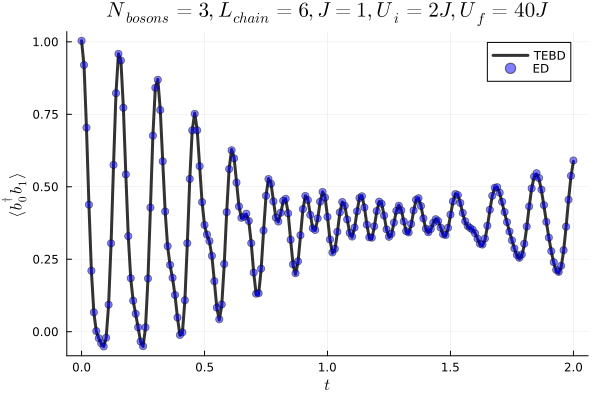

In [14]:
plot(Times_TEBD, Correlations_TEBD, label = "TEBD", color ="black", linewidth=3, alpha=0.8)
scatter!(Times_ED, Correlations_ED, label = "ED", color ="blue", alpha=0.5)

xlabel!(L"t")
ylabel!(L"\langle b^{\dagger}_{0} b_{1} \rangle")
title!(L"N_{bosons} = 3, L_{chain} = 6, J = 1, U_{i} = 2J, U_{f} = 40J")

**Figure 1 (with symmetries).** 

In [15]:
#Quantum Quench of Figure 1.

Max_N_Bosons = 9
L_Chain = 64
J = 1
Ui = 2*J
Uf = 40*J

Hi_MPO, sites = Build_MPO_Bose_Hubbard_Hamiltonian(Max_N_Bosons, L_Chain, J, Ui, false, true) #false: not given sites as parameter and true: symmetries.

nsweeps = 200
maxdim = [10,20,100,100,100,100,150,200,200,200,300] #maxdim - integer or array of integers specifying the maximum size allowed for the bond dimension or rank of the MPS being optimized
cutoff = [1E-10] 

DMRG_observer = DMRGObserver(;energy_tol=10e-8, minsweeps=10, energy_type=Float64)
Initial_MPS = MPS(sites, [2 for i=1:L_Chain]) #[2,2,...,2,2] means that in each site we have 1 boson. In this basis |1> is 0 boson, |2> is 1 boson, |3>s is 2 boson, etc.
energy_ground_state, psi_ground_state = dmrg(Hi_MPO,Initial_MPS; nsweeps, maxdim, cutoff, observer = DMRG_observer, outputlevel = 1) #randomMPS(sites,4) is the start point. Is a random MPS with bond dimension = number of bosons + 1

After sweep 1 energy=-83.78432996885174  maxlinkdim=10 maxerr=4.90E-06 time=15.410
After sweep 2 energy=-84.54152600952204  maxlinkdim=20 maxerr=2.11E-07 time=4.020
After sweep 3 energy=-84.65331641058418  maxlinkdim=71 maxerr=1.00E-10 time=7.099
After sweep 4 energy=-84.6828907434531  maxlinkdim=95 maxerr=9.99E-11 time=10.292
After sweep 5 energy=-84.68829151039672  maxlinkdim=90 maxerr=1.00E-10 time=10.047
After sweep 6 energy=-84.69058887712029  maxlinkdim=85 maxerr=1.00E-10 time=9.962
After sweep 7 energy=-84.69193979714  maxlinkdim=110 maxerr=9.99E-11 time=9.986
After sweep 8 energy=-84.69273655876127  maxlinkdim=107 maxerr=9.98E-11 time=10.685
After sweep 9 energy=-84.69318681289934  maxlinkdim=115 maxerr=9.97E-11 time=11.805
After sweep 10 energy=-84.6934491221604  maxlinkdim=145 maxerr=9.96E-11 time=13.287
After sweep 11 energy=-84.6935566398568  maxlinkdim=122 maxerr=1.00E-10 time=14.686
After sweep 12 energy=-84.6936188456734  maxlinkdim=171 maxerr=9.99E-11 time=17.249
After 

(-84.69363041201184, MPS
[1] ((dim=6|id=974|"Link,l=1") <Out>
 1: QN("Number",59) => 1
 2: QN("Number",60) => 1
 3: QN("Number",61) => 1
 4: QN("Number",62) => 1
 5: QN("Number",63) => 1
 6: QN("Number",64) => 1, (dim=10|id=365|"Qudit,Site,n=1") <Out>
 1: QN("Number",0) => 1
 2: QN("Number",1) => 1
 3: QN("Number",2) => 1
 4: QN("Number",3) => 1
 5: QN("Number",4) => 1
 6: QN("Number",5) => 1
 7: QN("Number",6) => 1
 8: QN("Number",7) => 1
 9: QN("Number",8) => 1
 10: QN("Number",9) => 1)
[2] ((dim=15|id=829|"Link,l=2") <Out>
 1: QN("Number",58) => 1
 2: QN("Number",59) => 2
 3: QN("Number",60) => 3
 4: QN("Number",61) => 3
 5: QN("Number",62) => 3
 6: QN("Number",63) => 2
 7: QN("Number",64) => 1, (dim=10|id=528|"Qudit,Site,n=2") <Out>
 1: QN("Number",0) => 1
 2: QN("Number",1) => 1
 3: QN("Number",2) => 1
 4: QN("Number",3) => 1
 5: QN("Number",4) => 1
 6: QN("Number",5) => 1
 7: QN("Number",6) => 1
 8: QN("Number",7) => 1
 9: QN("Number",8) => 1
 10: QN("Number",9) => 1, (dim=6|id=9

Now we will have 64 bosons:

In [17]:
Population = sum(expect(psi_ground_state, "N")) 

64.00000000000024

In [19]:
# f = h5open("Ground_State_Figure1.h5","w")
# write(f,"psi",psi_ground_state)
# close(f)

# f = h5open("Ground_State_Figure1.h5","r")
# psi = read(f,"psi",MPS)
# close(f)

In [20]:
Correlations_TEBD, Times_TEBD = TEBD_Time_Evolution_Expected_Value_Correlation(0.02,  psi_ground_state, Max_N_Bosons, L_Chain, J, Uf, 32, 33)
# Correlations_TEBD, Times_TEBD = TEBD_Time_Evolution_Expected_Value_Correlation_distance(0.02,  psi_ground_state, Max_N_Bosons, L_Chain, J, Uf, 1)

([0.9420754725127777, 0.8672798862000242, 0.6773795490618675], [0.0, 0.01, 0.02])

In [66]:
Correlations_TEBD, Times_TEBD = TEBD_Time_Evolution_Expected_Value_Correlation(2,  psi_ground_state, Max_N_Bosons, L_Chain, J, Uf, 32, 33, 200, true)

Correlations for t = 0.01 calculated.
Correlations for t = 0.02 calculated.
Correlations for t = 0.03 calculated.
Correlations for t = 0.04 calculated.
Correlations for t = 0.05 calculated.
Correlations for t = 0.06 calculated.
Correlations for t = 0.07 calculated.
Correlations for t = 0.08 calculated.
Correlations for t = 0.09 calculated.
Correlations for t = 0.1 calculated.
Correlations for t = 0.11 calculated.
Correlations for t = 0.12 calculated.
Correlations for t = 0.13 calculated.
Correlations for t = 0.14 calculated.
Correlations for t = 0.15 calculated.
Correlations for t = 0.16 calculated.
Correlations for t = 0.17 calculated.
Correlations for t = 0.18 calculated.
Correlations for t = 0.19 calculated.
Correlations for t = 0.2 calculated.
Correlations for t = 0.21 calculated.
Correlations for t = 0.22 calculated.
Correlations for t = 0.23 calculated.
Correlations for t = 0.24 calculated.
Correlations for t = 0.25 calculated.
Correlations for t = 0.26 calculated.
Correlations f

([0.9420754725127777, 0.8672818943159342, 0.677369952893609, 0.4494438858432627, 0.25327829246449907, 0.1205927261268226, 0.045142804562466145, 0.0036428917574780747, -0.019671981350574484, -0.02065863920766277  …  0.36517673378397325, 0.3440441719640629, 0.3367900132399428, 0.3493127538658479, 0.37407252291675763, 0.3953661493226423, 0.3996196392574264, 0.38379945880359156, 0.3571476060820775, 0.335397700059181], [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  1.91, 1.92, 1.93, 1.94, 1.95, 1.96, 1.97, 1.98, 1.99, 2.0])

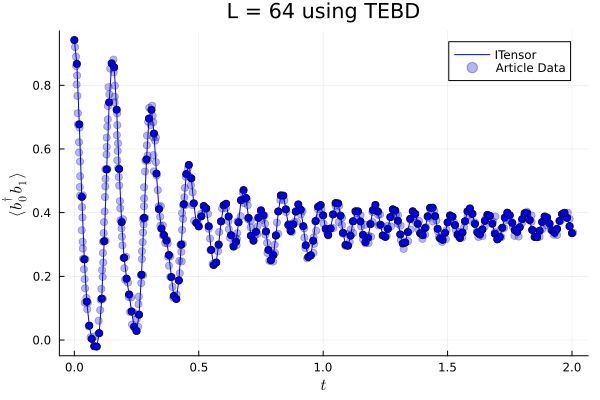

In [67]:
scatter(Times_TEBD, Correlations_TEBD, label = false, color = "blue")
plot!(Times_TEBD, Correlations_TEBD, label = "ITensor", color = "blue")

Figure1_Data = readdlm("txt_files/Hubbard_Fig 1.txt", ',', Float64)
scatter!(Figure1_Data[:,1], Figure1_Data[:,2], label = "Article Data", color = "blue", alpha = 0.3 )

xlabel!(L"t")
ylabel!(L"\langle b^{\dagger}_{0} b_{1} \rangle")
title!("L = 64 using TEBD")

In [68]:
# writedlm("txt_files/Correlations_TEBD.txt", Correlations_TEBD)
# writedlm("txt_files/Times_TEBD.txt", Times_TEBD)